In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import colorcet as cc
from matplotlib.colors import ListedColormap
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import pyarrow

C:\Users\Nissim\AppData\Local\Temp\ipykernel_26408\1722922730.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
base_path = '../data/'

In [3]:
cluster_dat = gpd.read_file(base_path + 'clustering_data.geojson')

In [4]:
cluster_dat.head()

,geoid,pov_rt,flood_risk,namelsad,NAME,tot_pop_1940,tot_pop_1950,tot_pop_1960,tot_pop_1970,tot_pop_1980,...,deciduous_forest,evergreen_forest,mixed_forest,shrub_scrub,grassland_herbaceous,pasture_hay,cultivated_crops,woody_wetlands,emergent_herbaceous_wetlands,geometry
0,3400100100,0.406424,0.693030,Absecon city,"Absecon city, Atlantic County, New Jersey",2084.0,2355.0,4320.0,6094.0,6859.0,...,0.015168,0.001250,0.028210,0.000915,0.001041,0.002462,0.003178,0.080904,0.251300,"POLYGON ((-74.53138 39.42627, -74.52991 39.425..."
1,3400102080,0.775740,0.971788,Atlantic City city,"Atlantic City city, Atlantic County, New Jersey",64094.0,61657.0,59544.0,47859.0,40199.0,...,0.000101,0.000101,0.000020,0.000525,0.000942,0.000000,0.000000,0.014594,0.311823,"POLYGON ((-74.50159 39.35726, -74.50053 39.356..."
2,3400107810,0.302975,0.966959,Brigantine city,"Brigantine city, Atlantic County, New Jersey",403.0,1267.0,4201.0,6741.0,8318.0,...,0.000928,0.000000,0.000192,0.001503,0.005833,0.000000,0.000832,0.015162,0.287935,"POLYGON ((-74.42199 39.38523, -74.41826 39.381..."
3,3400108680,0.569470,0.181154,Buena borough,"Buena borough, Atlantic County, New Jersey",3111.0,2640.0,3243.0,3283.0,3642.0,...,0.105284,0.003854,0.022989,0.004221,0.004542,0.003341,0.484193,0.061991,0.000315,"POLYGON ((-74.98262 39.51310, -74.97955 39.510..."
4,3400108710,0.449822,0.579928,Buena Vista township,"Buena Vista township, Atlantic County, New Jersey",4067.0,2106.0,3915.0,4239.0,6959.0,...,0.273240,0.023212,0.157290,0.009062,0.008720,0.005383,0.146850,0.223212,0.002444,"POLYGON ((-74.97211 39.50571, -74.97183 39.505..."


In [5]:
cluster_dat.columns

Index(['geoid', 'pov_rt', 'flood_risk', 'namelsad', 'NAME', 'tot_pop_1940',
       'tot_pop_1950', 'tot_pop_1960', 'tot_pop_1970', 'tot_pop_1980',
       'tot_pop_1990', 'tot_pop_2000', 'tot_pop_2010', 'tot_pop_2020',
       'size_class', 'pct_res_vac', 'open_water', 'developed_open_space',
       'developed_low_intensity', 'developed_medium_intensity',
       'developed_high_intensity', 'barren_land_rock_sand_clay',
       'deciduous_forest', 'evergreen_forest', 'mixed_forest', 'shrub_scrub',
       'grassland_herbaceous', 'pasture_hay', 'cultivated_crops',
       'woody_wetlands', 'emergent_herbaceous_wetlands', 'geometry'],
      dtype='object')

<Axes: >

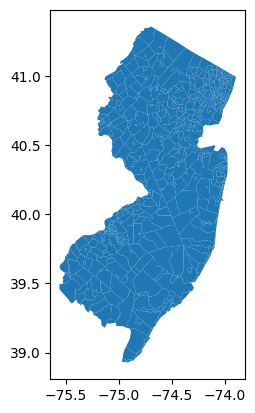

In [6]:
cluster_dat.plot()

In [7]:
# calculate the pct 70 year pop change from tot_pop_1950 and tot_pop_2020
cluster_dat['pct_70_year_pop_change'] = ((cluster_dat['tot_pop_2020'] - cluster_dat['tot_pop_1950']) / cluster_dat['tot_pop_1950']) * 100

In [81]:
# select the following columns: P200_I_PFS, FLD_PFS, pct_thirty_yr_pop_change, geometry
retreat_index_gdf = cluster_dat[['pov_rt', 'flood_risk', 'pct_70_year_pop_change', 'developed_high_intensity', 'tot_pop_2020', 'geometry']]

In [82]:
retreat_index_gdf.head()

,pov_rt,flood_risk,pct_70_year_pop_change,developed_high_intensity,tot_pop_2020,geometry
0,0.406424,0.693030,287.983015,0.024833,9137.0,"POLYGON ((-74.53138 39.42627, -74.52991 39.425..."
1,0.775740,0.971788,-37.562645,0.154158,38497.0,"POLYGON ((-74.50159 39.35726, -74.50053 39.356..."
2,0.302975,0.966959,508.997632,0.058109,7716.0,"POLYGON ((-74.42199 39.38523, -74.41826 39.381..."
3,0.569470,0.181154,70.492424,0.015367,4501.0,"POLYGON ((-74.98262 39.51310, -74.97955 39.510..."
4,0.449822,0.579928,233.950617,0.003296,7033.0,"POLYGON ((-74.97211 39.50571, -74.97183 39.505..."


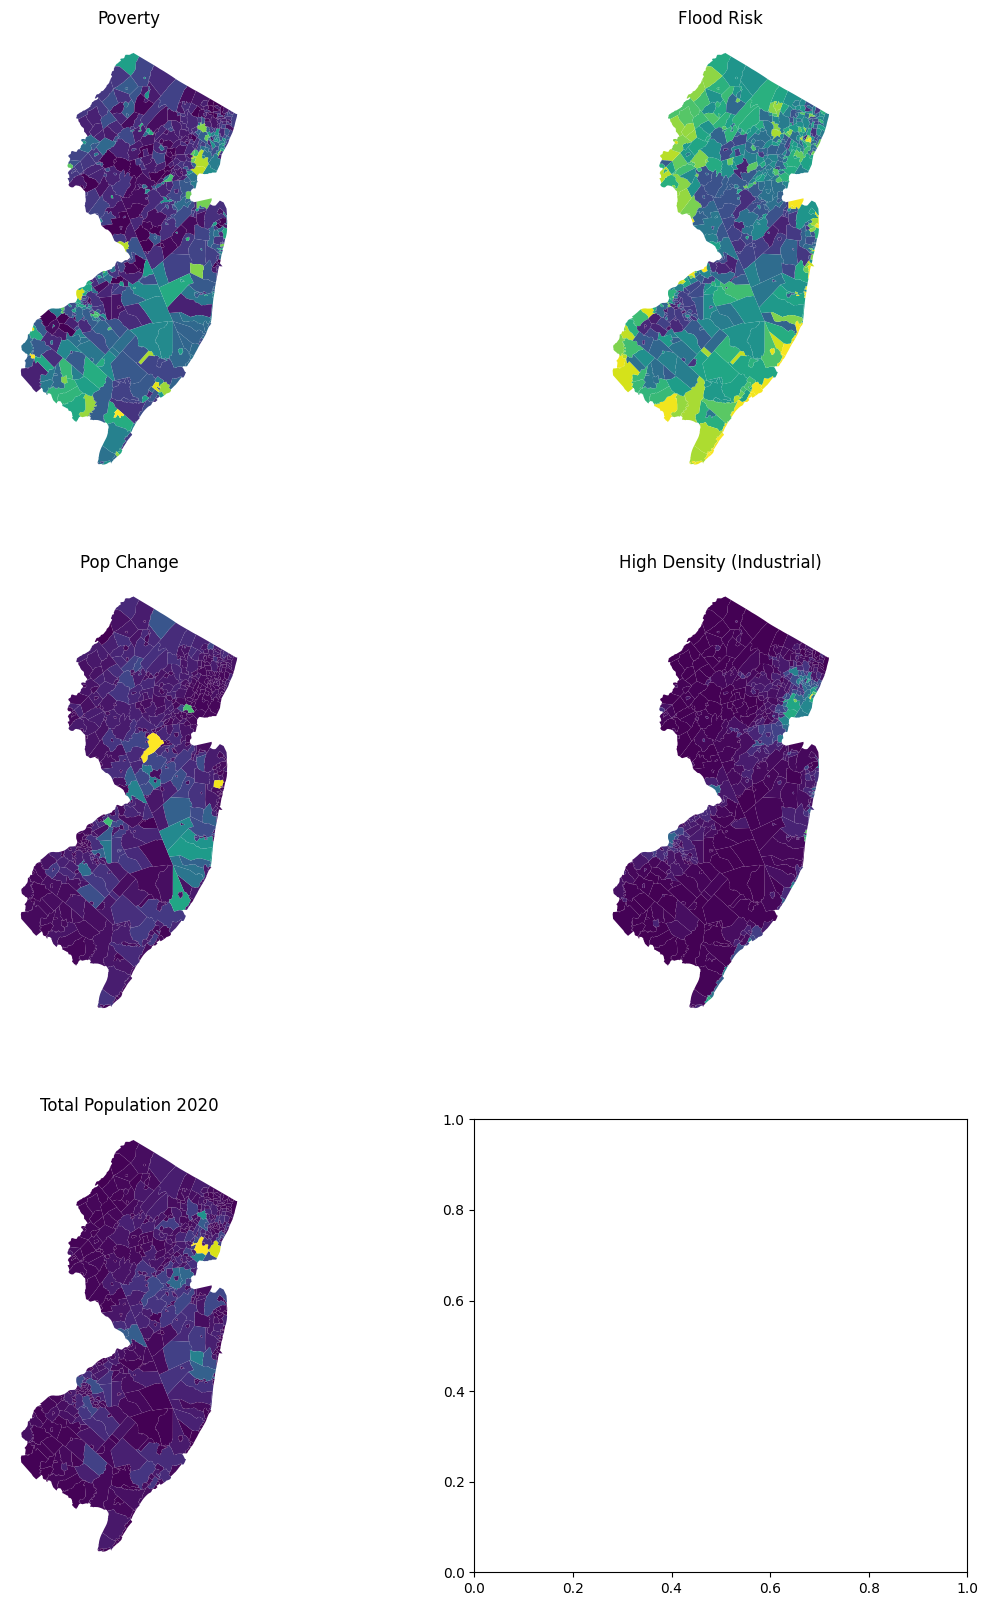

In [83]:
# plot maps of each of the numeric cols in the retreat_index_gdf
fig, ax = plt.subplots(3, 2, figsize=(14, 20))
retreat_index_gdf.plot(column='pov_rt', cmap='viridis', ax=ax[0][0])
ax[0][0].set_title('Poverty')
ax[0][0].axis('off')

retreat_index_gdf.plot(column='flood_risk', cmap='viridis', ax=ax[0][1])
ax[0][1].set_title('Flood Risk')
ax[0][1].axis('off')

retreat_index_gdf.plot(column='pct_70_year_pop_change', cmap='viridis', ax=ax[1][0])
ax[1][0].set_title('Pop Change')
ax[1][0].axis('off')

retreat_index_gdf.plot(column='developed_high_intensity', cmap='viridis', ax=ax[1][1])
ax[1][1].set_title('High Density (Industrial)')
ax[1][1].axis('off')

retreat_index_gdf.plot(column='tot_pop_2020', cmap='viridis', ax=ax[2][0])
ax[2][0].set_title('Total Population 2020')
ax[2][0].axis('off')

plt.show()

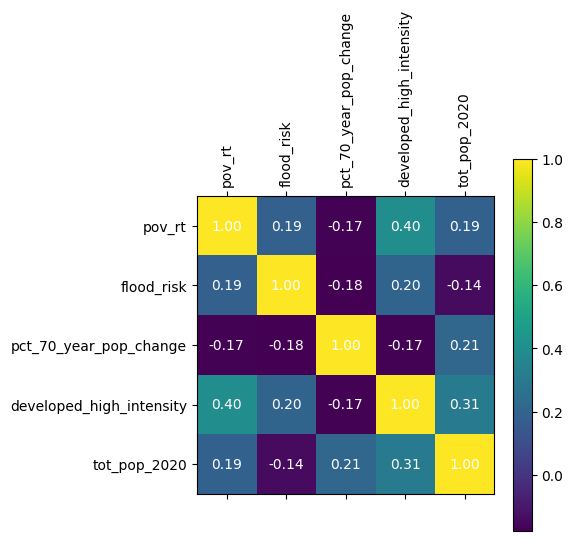

In [84]:
# Exclude non-numeric columns
numeric_cols = retreat_index_gdf.select_dtypes(include=[np.number]).columns

# Calculate correlation matrix
corr = retreat_index_gdf[numeric_cols].corr()

# Plot correlation matrix
plt.matshow(corr)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.colorbar()

# Add correlation values
for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        plt.text(j, i, f'{corr.iloc[i, j]:.2f}', ha='center', va='center', color='w')

plt.show()

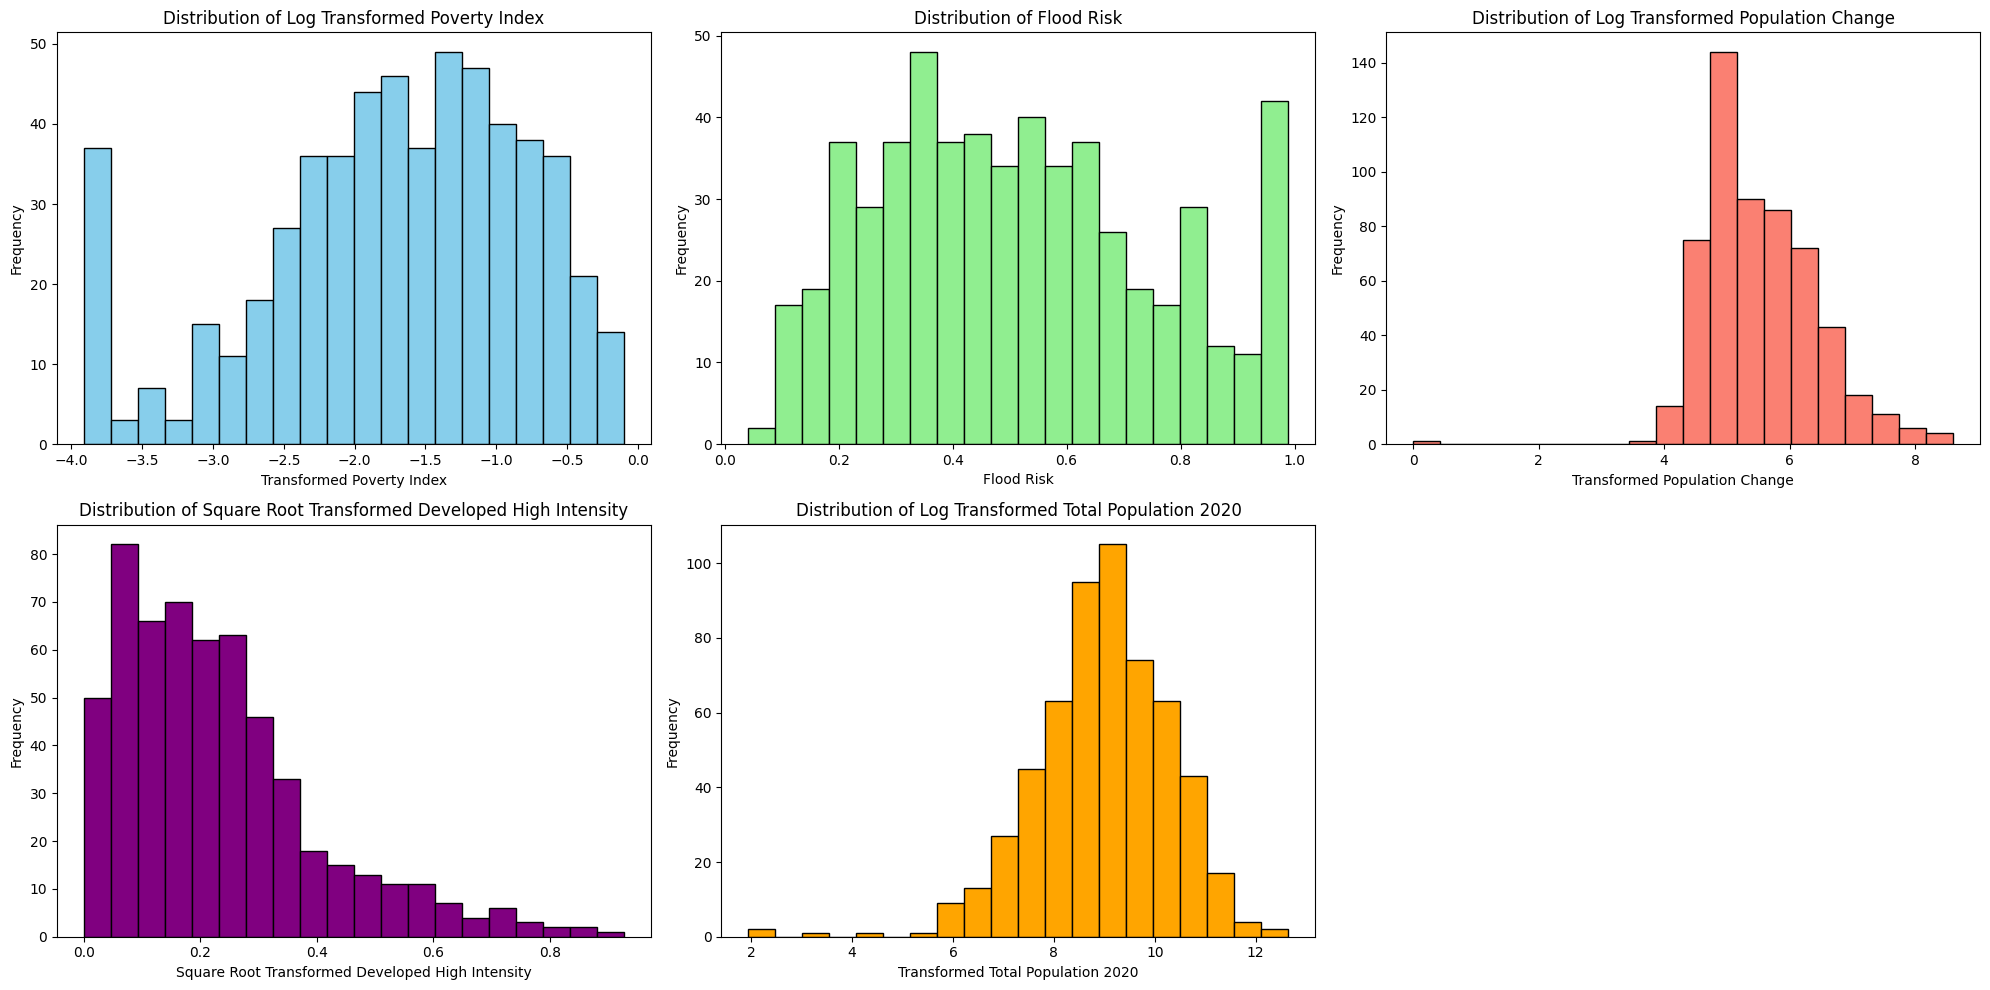

In [85]:
# Histograms for the four variables
plt.figure(figsize=(20, 10))

# Function to apply log transformation
def log_transform(column):
    if (column <= 0).any():
        min_value = column.min()
        shift_constant = np.abs(min_value) + 1
        return np.log(column + shift_constant)
    else:
        return np.log(column)

# Histogram for Poverty Index
plt.subplot(2, 3, 1)
transformed_pov_rt = log_transform(retreat_index_gdf['pov_rt'])
plt.hist(transformed_pov_rt, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Transformed Poverty Index')
plt.ylabel('Frequency')
plt.title('Distribution of Log Transformed Poverty Index')

# Histogram for Flood Risk
plt.subplot(2, 3, 2)
plt.hist(retreat_index_gdf['flood_risk'], bins=20, color='lightgreen', edgecolor='black')
plt.xlabel('Flood Risk')
plt.ylabel('Frequency')
plt.title('Distribution of Flood Risk')

# Histogram for Population Change
plt.subplot(2, 3, 3)
transformed_pop_change = log_transform(retreat_index_gdf['pct_70_year_pop_change'])
plt.hist(transformed_pop_change, bins=20, color='salmon', edgecolor='black')
plt.xlabel('Transformed Population Change')
plt.ylabel('Frequency')
plt.title('Distribution of Log Transformed Population Change')

# Histogram for Developed High Intensity
plt.subplot(2, 3, 4)
transformed_developed_high_intensity = np.sqrt(retreat_index_gdf['developed_high_intensity'])
plt.hist(transformed_developed_high_intensity, bins=20, color='purple', edgecolor='black')
plt.xlabel('Square Root Transformed Developed High Intensity')
plt.ylabel('Frequency')
plt.title('Distribution of Square Root Transformed Developed High Intensity')


# Histogram for Total Population
plt.subplot(2, 3, 5)
transformed_tot_pop_2020 = log_transform(retreat_index_gdf['tot_pop_2020'])
plt.hist(transformed_tot_pop_2020, bins=20, color='orange', edgecolor='black')
plt.xlabel('Transformed Total Population 2020')
plt.ylabel('Frequency')
plt.title('Distribution of Log Transformed Total Population 2020')

plt.tight_layout()
plt.show()

In [86]:
from sklearn.preprocessing import StandardScaler

# Step 1: Apply transformations
retreat_index_gdf['log_pov_rt'] = np.log(retreat_index_gdf['pov_rt'])
retreat_index_gdf['log_tot_pop_2020'] = np.log(retreat_index_gdf['tot_pop_2020'])
retreat_index_gdf['sqrt_flood_risk'] = np.sqrt(retreat_index_gdf['flood_risk'])
retreat_index_gdf['squared_developed_high_intensity'] = retreat_index_gdf['developed_high_intensity'] ** 2

# Step 2: Z-score normalize the variables
scaler = StandardScaler()
variables_to_normalize = ['log_pov_rt', 'sqrt_flood_risk', 'pct_70_year_pop_change', 'squared_developed_high_intensity', 'log_tot_pop_2020']
# Drop NA values from the dataframe to avoid errors in scaling and clustering
cleaned_gdf = retreat_index_gdf.dropna(subset=variables_to_normalize)
normalized_data = scaler.fit_transform(cleaned_gdf[variables_to_normalize])
normalized_df = pd.DataFrame(normalized_data, columns=variables_to_normalize, index=cleaned_gdf.index)

c:\Users\Nissim\Documents\GitHub\mach-superstudio\.venv\lib\site-packages\geopandas\geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\Nissim\Documents\GitHub\mach-superstudio\.venv\lib\site-packages\geopandas\geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\Nissim\Documents\GitHub\mach-superstudio\.venv\lib\site-packages\geopandas\geodataframe.py:1525: SettingWithCopyWarning: 
A value is tr

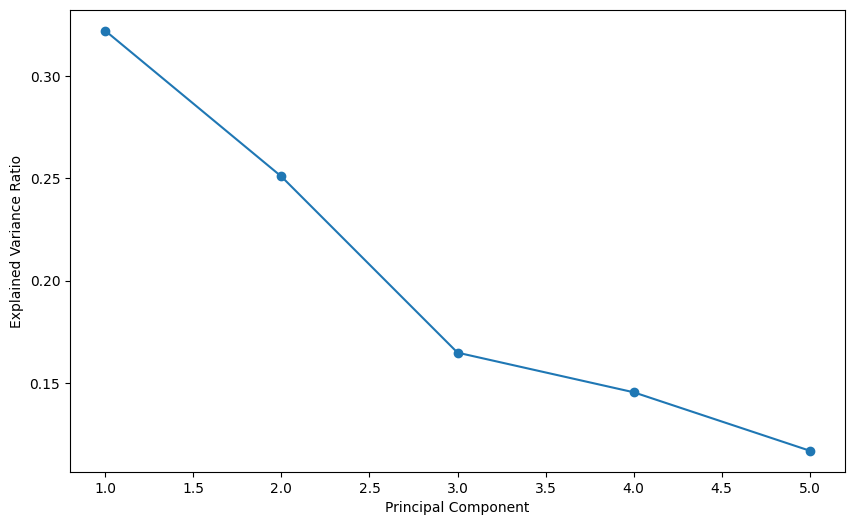

In [87]:
# run PCA on the normalized data to show which variables are most important
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(normalized_df)

# Plot the explained variance ratio
plt.figure(figsize=(10, 6))

plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')

plt.show()

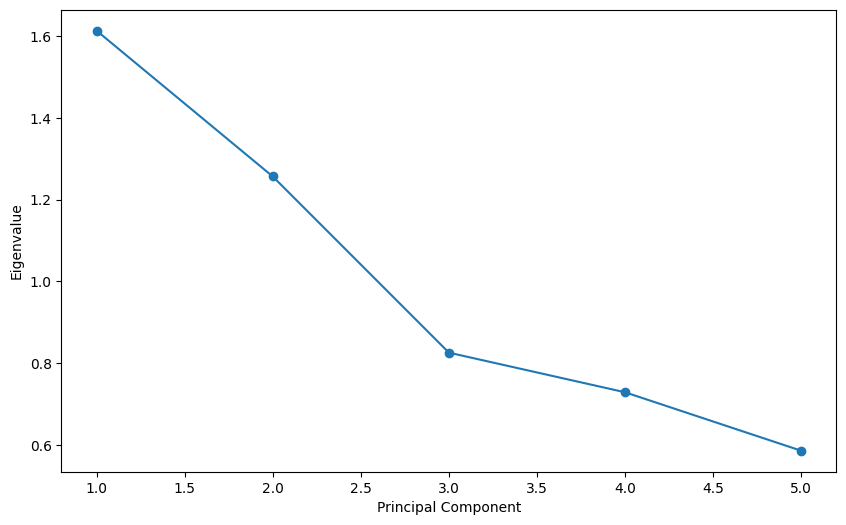

In [88]:
# show the eigenvalues of each componnet

plt.figure(figsize=(10, 6))

plt.plot(range(1, len(pca.explained_variance_) + 1), pca.explained_variance_, marker='o')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')

plt.show()

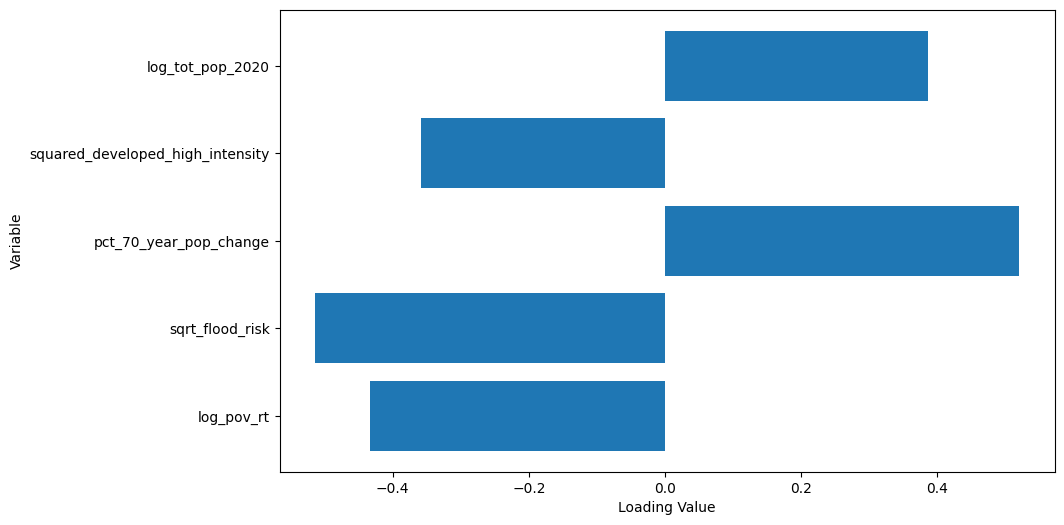

In [89]:
# show which variables are most important in each component
# Create a DataFrame with the loadings

loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i}' for i in range(1, len(pca.components_) + 1)], index=variables_to_normalize)

# Plot the loadings
plt.figure(figsize=(10, 6))

plt.barh(loadings.index, loadings['PC1'])
plt.xlabel('Loading Value')
plt.ylabel('Variable')

plt.show()

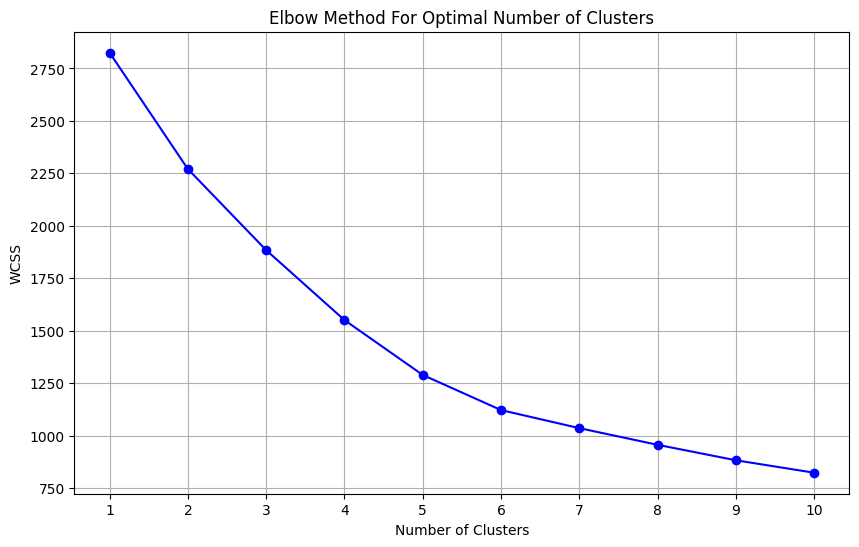

In [90]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Step 1: Compute WCSS for different numbers of clusters
wcss = []  # List to store WCSS values
cluster_range = range(1, 11)  # Adjust the range as needed

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(normalized_df)  # Assuming 'normalized_df' is your pre-processed data
    wcss.append(kmeans.inertia_)  # inertia_ is the WCSS

# Step 2: Plot the elbow plot
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, wcss, marker='o', linestyle='-', color='blue')
plt.title('Elbow Method For Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.xticks(cluster_range)
plt.grid(True)
plt.show()

In [91]:
# Step 3: Cluster the normalized and cleaned data
kmeans = KMeans(n_clusters=7, random_state=42)  # Adjust the number of clusters as needed
clusters = kmeans.fit_predict(normalized_df)

In [92]:
cleaned_gdf['cluster'] = clusters  # Add cluster labels to the cleaned GeoDataFrame

In [93]:
# Step 4: Map the clusters
# Ensure the GeoDataFrame for plotting includes the cluster information
retreat_index_gdf = retreat_index_gdf.merge(cleaned_gdf[['cluster']], left_index=True, right_index=True, how='left')

In [94]:
retreat_index_gdf.head()

,pov_rt,flood_risk,pct_70_year_pop_change,developed_high_intensity,tot_pop_2020,geometry,log_pov_rt,log_tot_pop_2020,sqrt_flood_risk,squared_developed_high_intensity,cluster
0,0.406424,0.693030,287.983015,0.024833,9137.0,"POLYGON ((-74.53138 39.42627, -74.52991 39.425...",-0.900360,9.120087,0.832484,0.000617,2
1,0.775740,0.971788,-37.562645,0.154158,38497.0,"POLYGON ((-74.50159 39.35726, -74.50053 39.356...",-0.253938,10.558336,0.985793,0.023765,2
2,0.302975,0.966959,508.997632,0.058109,7716.0,"POLYGON ((-74.42199 39.38523, -74.41826 39.381...",-1.194105,8.951051,0.983341,0.003377,2
3,0.569470,0.181154,70.492424,0.015367,4501.0,"POLYGON ((-74.98262 39.51310, -74.97955 39.510...",-0.563049,8.412055,0.425622,0.000236,5
4,0.449822,0.579928,233.950617,0.003296,7033.0,"POLYGON ((-74.97211 39.50571, -74.97183 39.505...",-0.798903,8.858369,0.761530,0.000011,5


In [95]:
retreat_index_gdf.columns

Index(['pov_rt', 'flood_risk', 'pct_70_year_pop_change',
       'developed_high_intensity', 'tot_pop_2020', 'geometry', 'log_pov_rt',
       'log_tot_pop_2020', 'sqrt_flood_risk',
       'squared_developed_high_intensity', 'cluster'],
      dtype='object')

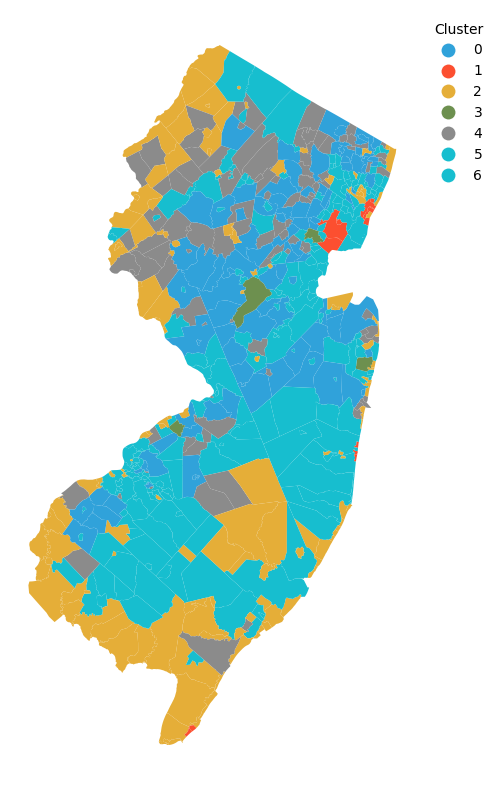

In [96]:
# Select a colorcet palette and create a ListedColormap
colors = cc.glasbey_hv[:6]  # For 7 clusters
cmap = ListedColormap(colors)

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))  # Increase figure size
retreat_index_gdf.plot(column='cluster', cmap=cmap, legend=True, ax=ax, categorical=True)

# Adjusting the legend to be outside
legend = ax.get_legend()
if legend:
    legend.set_bbox_to_anchor((1.2, 1))  # Move the legend further right
    legend.set_title('Cluster')
    legend.set_frame_on(False)  # Remove the frame of the legend

# Remove the frame, ticks, and labels
ax.set_frame_on(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')

plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the layout to leave space for the legend
plt.show()


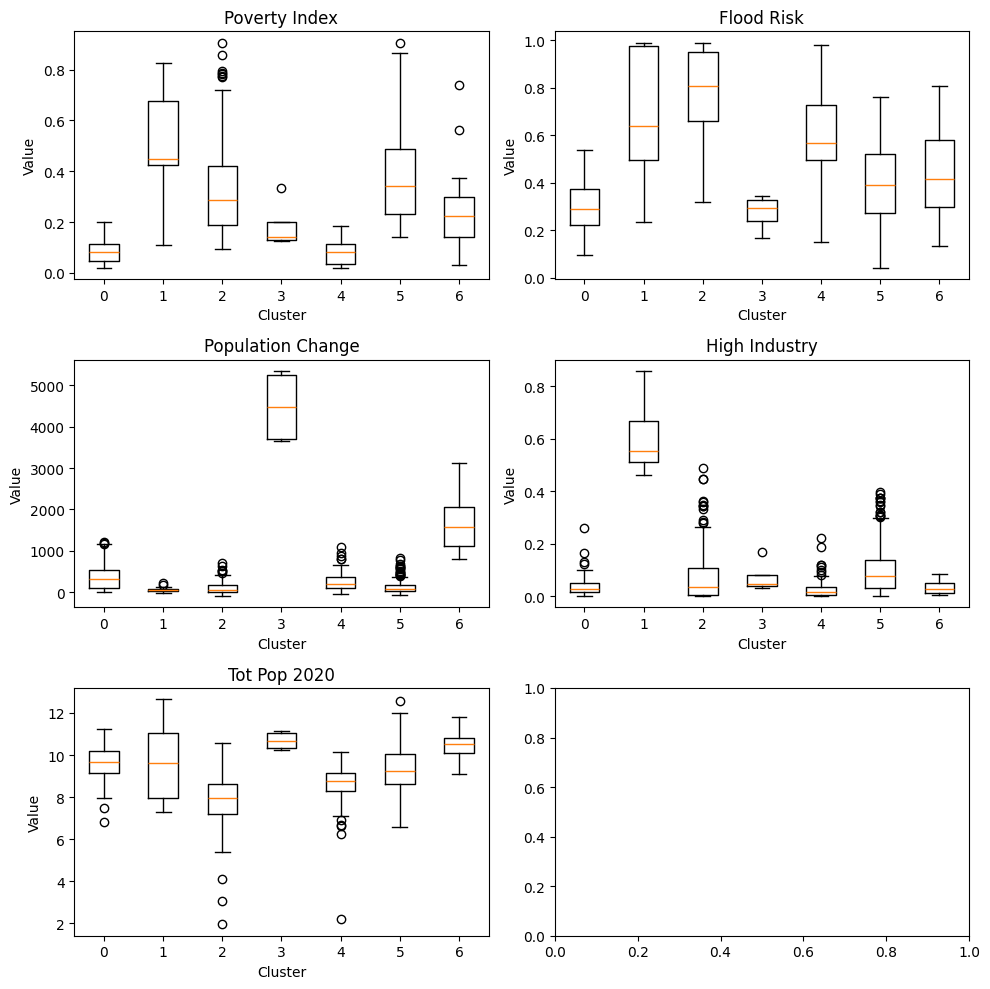

In [97]:
# Variables to plot
variables = ['pov_rt', 'flood_risk', 'pct_70_year_pop_change', 'developed_high_intensity', 'log_tot_pop_2020']
titles = ['Poverty Index', 'Flood Risk', 'Population Change', 'High Industry', 'Tot Pop 2020']

# Creating box plots
fig, axes = plt.subplots(3, 2, figsize=(10, 10))

# Flatten the axes array and iterate over it
for ax, var, title in zip(axes.flatten(), variables, titles):

    # Prepare data for plotting: extract values for each cluster
    data_to_plot = [retreat_index_gdf[retreat_index_gdf['cluster'] == cluster][var] for cluster in sorted(retreat_index_gdf['cluster'].unique())]
    
    # Create box plot
    ax.boxplot(data_to_plot)
    
    # Setting titles and labels
    ax.set_title(title)
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Value')
    ax.set_xticklabels(sorted(retreat_index_gdf['cluster'].unique()))

plt.tight_layout()
plt.show()


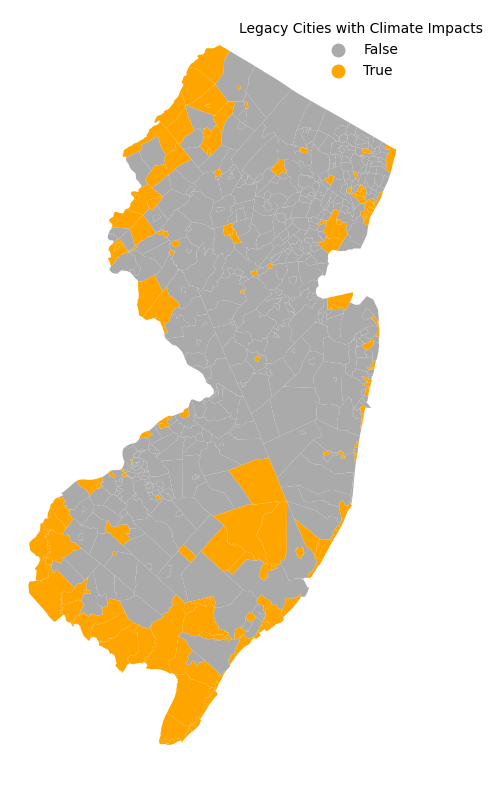

In [104]:
# Create a new column 'highlight' that is True for clusters 2 and 3, and False otherwise
retreat_index_gdf['highlight'] = retreat_index_gdf['cluster'].isin([1, 2])

# Create a color map for the highlight: use bright colors for True (clusters 2 and 3) and a dull color for False
highlight_cmap = ListedColormap(['#aaaaaa', '#ff0000', 'orange'])

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))  # Increase figure size
retreat_index_gdf.plot(column='highlight', cmap=highlight_cmap, legend=True, ax=ax, categorical=True)

# Adjusting the legend to be outside
legend = ax.get_legend()
if legend:
    legend.set_bbox_to_anchor((1.2, 1))  # Move the legend further right
    legend.set_title('Legacy Cities with Climate Impacts')
    legend.set_frame_on(False)  # Remove the frame of the legend

# Remove the frame, ticks, and labels
ax.set_frame_on(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')

plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the layout to leave space for the legend
plt.show()

In [99]:
# read the nj_cest from a geoparquet file
nj_cejst = gpd.read_parquet(base_path + 'nj_cejst.parquet')

In [100]:
nj_cejst.head()

,GEOID10,SF,CF,DF_PFS,AF_PFS,HDF_PFS,DSF_PFS,EBF_PFS,EALR_PFS,EBLR_PFS,...,AGE_10,AGE_MIDDLE,AGE_OLD,TA_COU_116,TA_COUNT_C,TA_PERC,TA_PERC_FE,UI_EXP,THRHLD,geometry
40677,34015501210,New Jersey,Gloucester County,NaN,NaN,NaN,0.43,0.38,0.30,0.36,...,0.12,0.73,0.13,NaN,None,NaN,NaN,Nation,21,"POLYGON ((-75.08790 39.71565, -75.08840 39.715..."
40678,34015501301,New Jersey,Gloucester County,NaN,NaN,NaN,0.54,0.44,0.20,0.36,...,0.07,0.76,0.16,NaN,None,NaN,NaN,Nation,21,"POLYGON ((-75.11347 39.73927, -75.11351 39.739..."
40679,34015501303,New Jersey,Gloucester County,NaN,NaN,NaN,0.54,0.61,0.34,0.39,...,0.08,0.66,0.24,NaN,None,NaN,NaN,Nation,21,"POLYGON ((-75.13190 39.72464, -75.13088 39.723..."
40680,34015501900,New Jersey,Gloucester County,NaN,NaN,NaN,0.40,0.63,0.67,0.39,...,0.07,0.76,0.16,NaN,None,NaN,NaN,Nation,21,"POLYGON ((-75.19511 39.66308, -75.19538 39.663..."
40681,34015500300,New Jersey,Gloucester County,NaN,NaN,NaN,0.80,0.57,0.50,0.74,...,0.10,0.76,0.13,NaN,None,NaN,NaN,Nation,21,"POLYGON ((-75.19502 39.87752, -75.19471 39.877..."


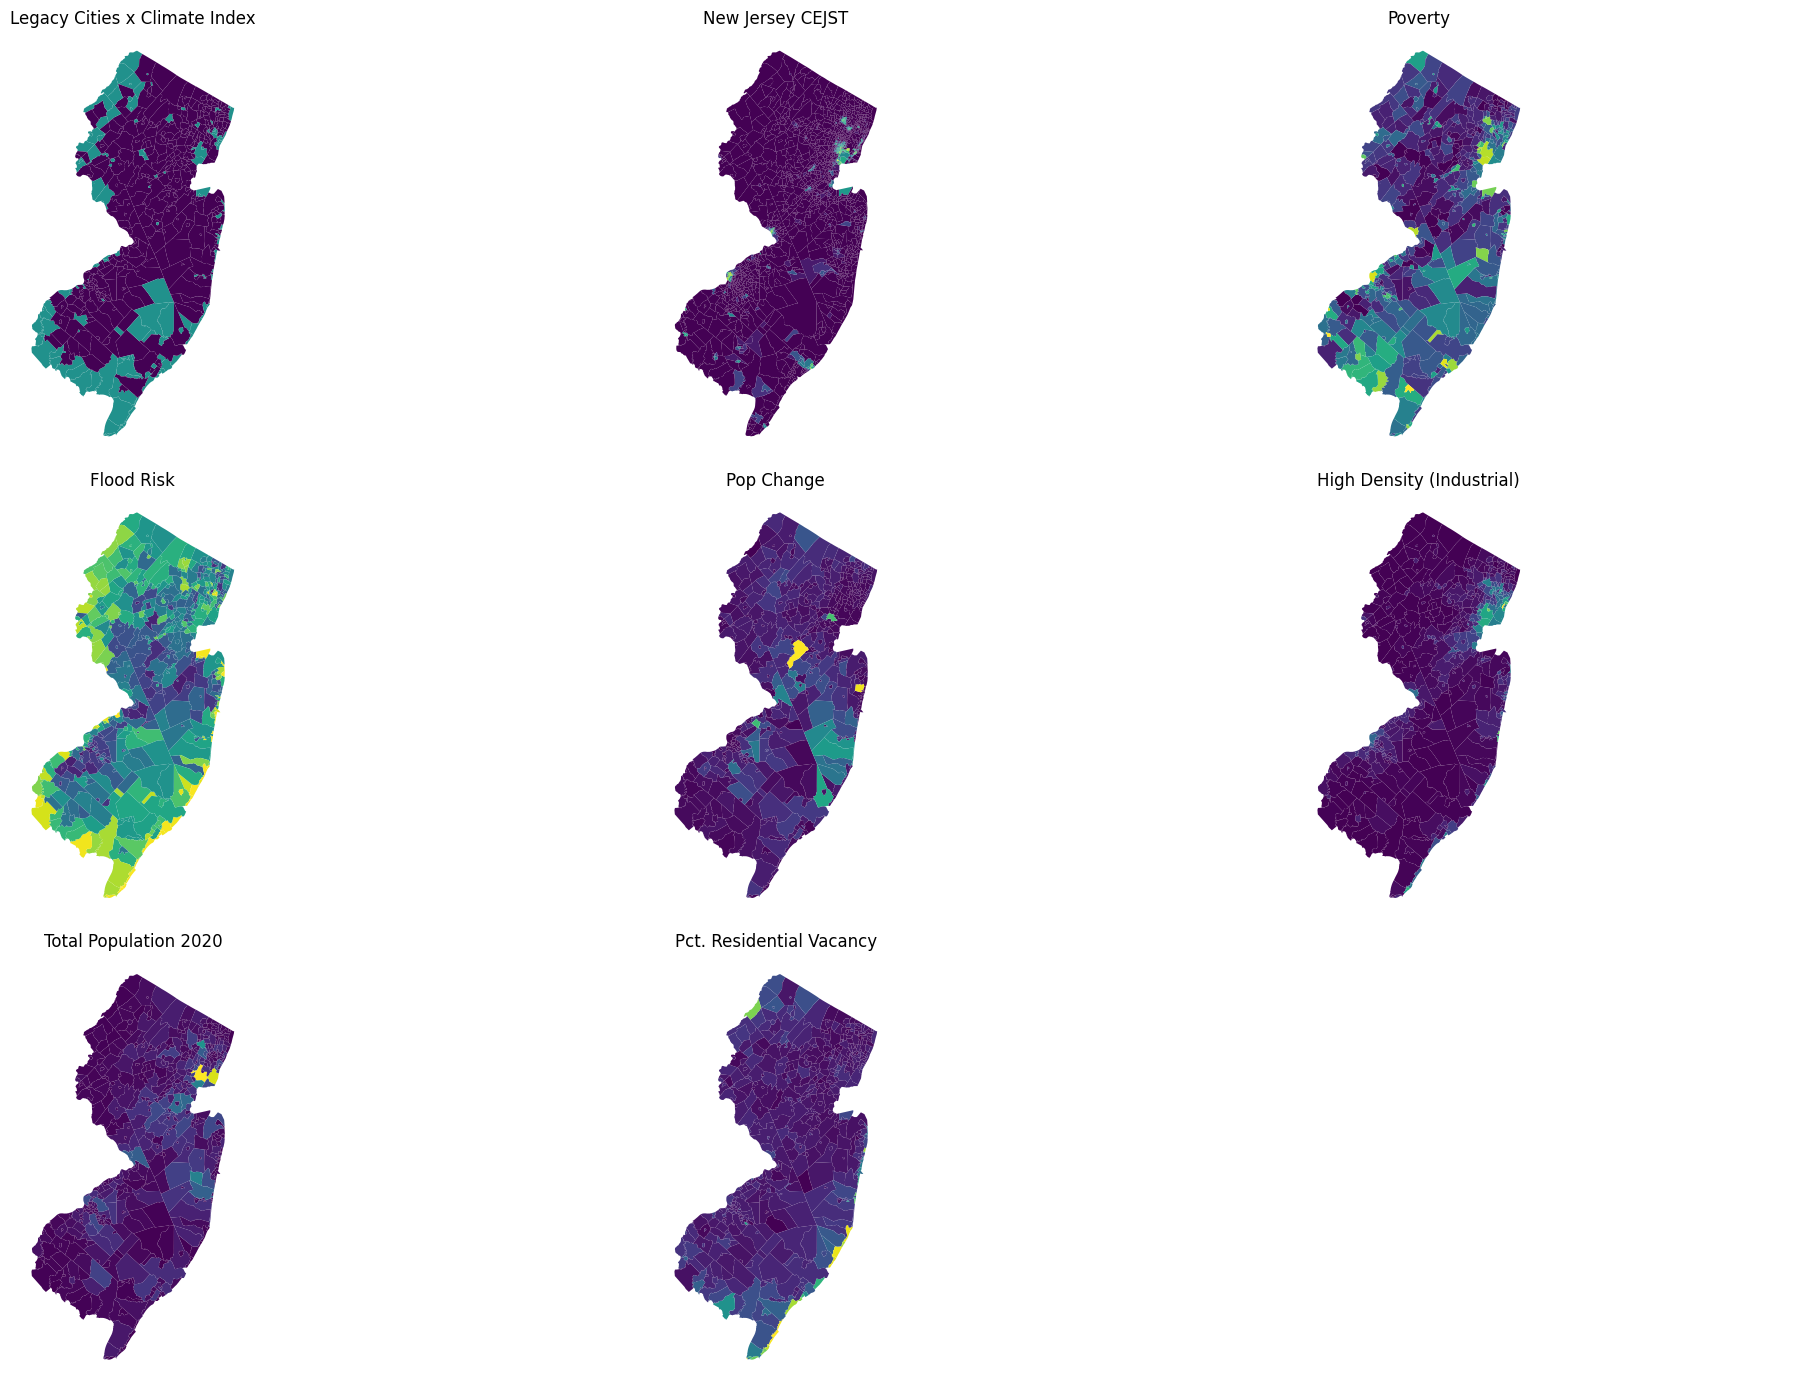

In [105]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Create a new column 'highlight' that is True for clusters 2 and 3, and False otherwise
retreat_index_gdf['highlight'] = retreat_index_gdf['cluster'].isin([1, 2])

# Create a color map for the highlight
highlight_cmap = ListedColormap(['#aaaaaa', '#ff0000', 'orange'])

# Set up a figure with two subplots (axes)
fig, ax = plt.subplots(3, 3, figsize=(21, 14))  # Adjusted figure size for six plots

viridis = plt.colormaps['viridis']
newcolors = viridis(np.linspace(0, 0.5, 256))
newcmp = LinearSegmentedColormap.from_list('PurpleGreenViridis', newcolors)

# Plotting with the custom colormap
retreat_index_gdf.plot(column='highlight', cmap=newcmp, ax=ax[0, 0], categorical=True)
ax[0, 0].set_title('Legacy Cities x Climate Index')  # Title for the first map
ax[0, 0].axis('off')  # Remove axes and ticks

# Second map (3x3 position: 1,2)
nj_cest.plot(column='TC', cmap='viridis', ax=ax[0, 1])
ax[0, 1].set_title('New Jersey CEJST')  # Title for the second map
ax[0, 1].axis('off')  # Remove axes and ticks

# Plot for 'pov_rt' (3x3 position: 1,3)
retreat_index_gdf.plot(column='pov_rt', cmap='viridis', ax=ax[0, 2])
ax[0, 2].set_title('Poverty')
ax[0, 2].axis('off')  # Remove axes and ticks

# Plot for 'flood_risk' (3x3 position: 2,1)
retreat_index_gdf.plot(column='flood_risk', cmap='viridis', ax=ax[1, 0])
ax[1, 0].set_title('Flood Risk')
ax[1, 0].axis('off')  # Remove axes and ticks

# Plot for 'pct_70_year_pop_change' (3x3 position: 2,2)
retreat_index_gdf.plot(column='pct_70_year_pop_change', cmap='viridis', ax=ax[1, 1])
ax[1, 1].set_title('Pop Change')
ax[1, 1].axis('off')  # Remove axes and ticks


# Plot for 'developed_high_intensity' (3x3 position: 2,3)
retreat_index_gdf.plot(column='developed_high_intensity', cmap='viridis', ax=ax[1, 2])
ax[1, 2].set_title('High Density (Industrial)')
ax[1, 2].axis('off')  # Remove axes and ticks


# Plot for 'tot_pop_2020' (3x3 position: 3,1)
retreat_index_gdf.plot(column='tot_pop_2020', cmap='viridis', ax=ax[2, 0])
ax[2, 0].set_title('Total Population 2020')
ax[2, 0].axis('off')  # Remove axes and ticks


# Plot for 'pct_res_vac' (3x3 position: 3,2)
cluster_dat.plot(column='pct_res_vac', cmap='viridis', ax=ax[2, 1])
ax[2, 1].set_title('Pct. Residential Vacancy')
ax[2, 1].axis('off')  # Remove axes and ticks

# Turn off the unused subplot (3x3 position: 3,3)
ax[2, 2].axis('off')

# Adjust the layout and show the figure
plt.tight_layout()
plt.show()

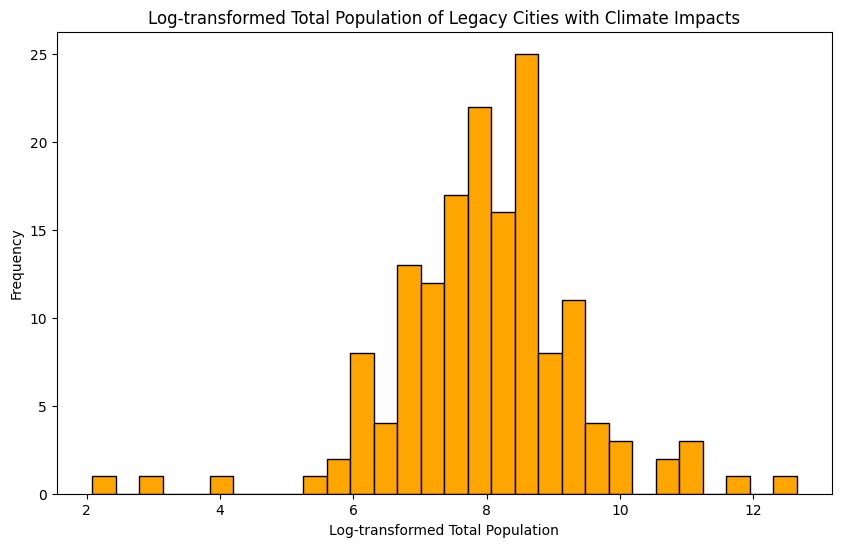

In [110]:
# add a histogram showing the total population of each municipality in the 'highlight' column
fig, ax = plt.subplots(figsize=(10, 6))

# Filter DataFrame for rows where 'highlight' is True, apply log transformation to 'tot_pop_2020', and plot histogram
np.log1p(retreat_index_gdf[retreat_index_gdf['highlight']]['tot_pop_2020']).plot.hist(ax=ax, bins=30, color='orange', edgecolor='black')
plt.xlabel('Log-transformed Total Population')
plt.ylabel('Frequency')
plt.title('Log-transformed Total Population of Legacy Cities with Climate Impacts')

plt.show()

In [112]:
# print out a list of the municipalities in the highlight column where the log-transformed total population is within 2 standard deviations of the mean
# Calculate the mean and standard deviation of the log-transformed total population
mean_log_pop = np.log1p(retreat_index_gdf['tot_pop_2020']).mean()
std_log_pop = np.log1p(retreat_index_gdf['tot_pop_2020']).std()

# Filter the DataFrame for rows where 'highlight' is True and the log-transformed total population is within 2 standard deviations of the mean
highlighted_municipalities = retreat_index_gdf[(retreat_index_gdf['highlight']) & (np.log1p(retreat_index_gdf['tot_pop_2020']) >= mean_log_pop - 2 * std_log_pop) & (np.log1p(retreat_index_gdf['tot_pop_2020']) <= mean_log_pop + 2 * std_log_pop)]

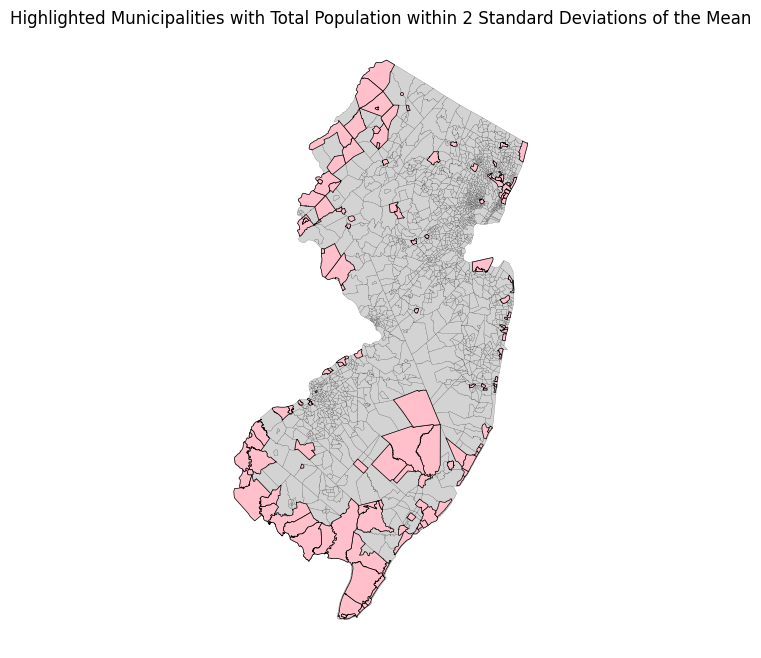

In [116]:
# plot the highlighted municipalities on a map
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the base map
nj_cejst.plot(ax=ax, color='lightgrey', edgecolor='black', linewidth=0.1)

# Plot the highlighted municipalities
highlighted_municipalities.plot(ax=ax, color='pink', edgecolor='black', linewidth=0.5)

# Add a title

plt.title('Highlighted Municipalities with Total Population within 2 Standard Deviations of the Mean')

# Remove the axis
ax.axis('off')

plt.show()

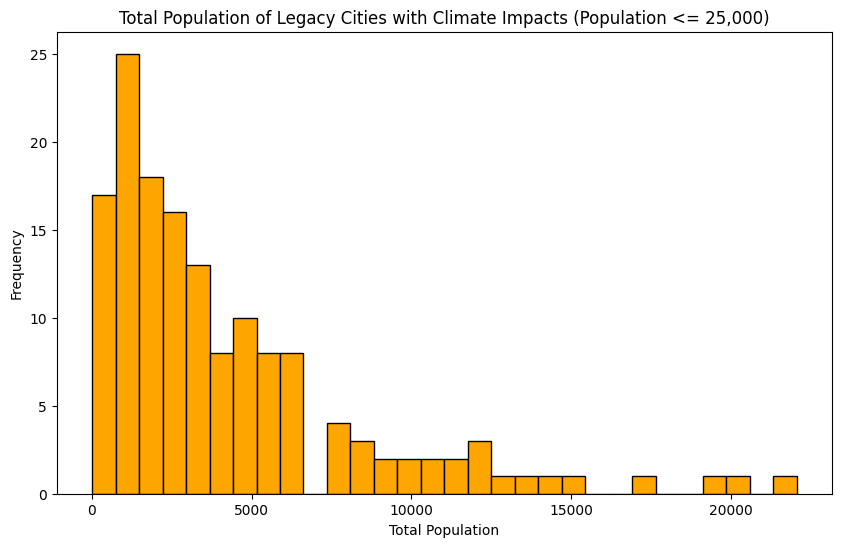

In [107]:
# add a histogram showing the total population of each municipality in the 'highlight' column
fig, ax = plt.subplots(figsize=(10, 6))

# Filter DataFrame for rows where 'highlight' is True and 'tot_pop_2020' is <= 25000, then plot histogram
retreat_index_gdf[(retreat_index_gdf['highlight']) & (retreat_index_gdf['tot_pop_2020'] <= 25000)]['tot_pop_2020'].plot.hist(ax=ax, bins=30, color='orange', edgecolor='black')
plt.xlabel('Total Population')
plt.ylabel('Frequency')
plt.title('Total Population of Legacy Cities with Climate Impacts (Population <= 25,000)')

plt.show()